# Temporal Difference Learning (TDE)

In [3]:
from temporal_difference_learning import TemporalDifferenceLearning
import matplotlib.pyplot as plt
import numpy as np

## 1. Recreate figure 9.2

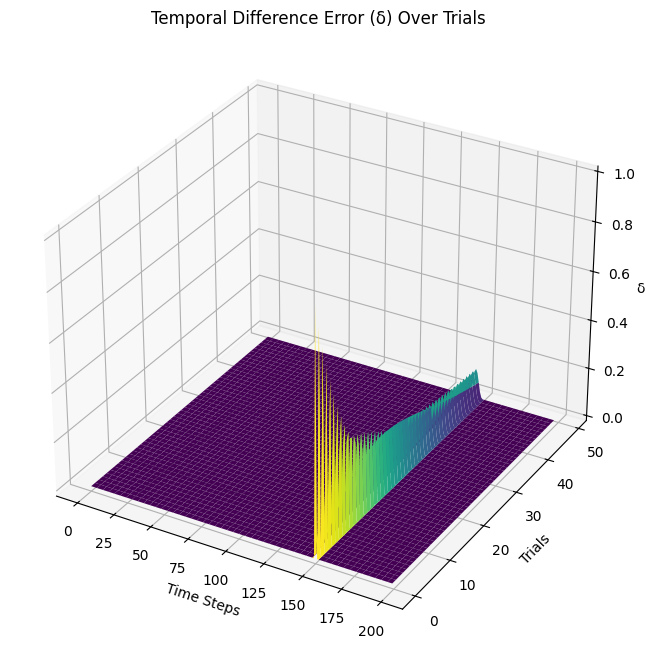

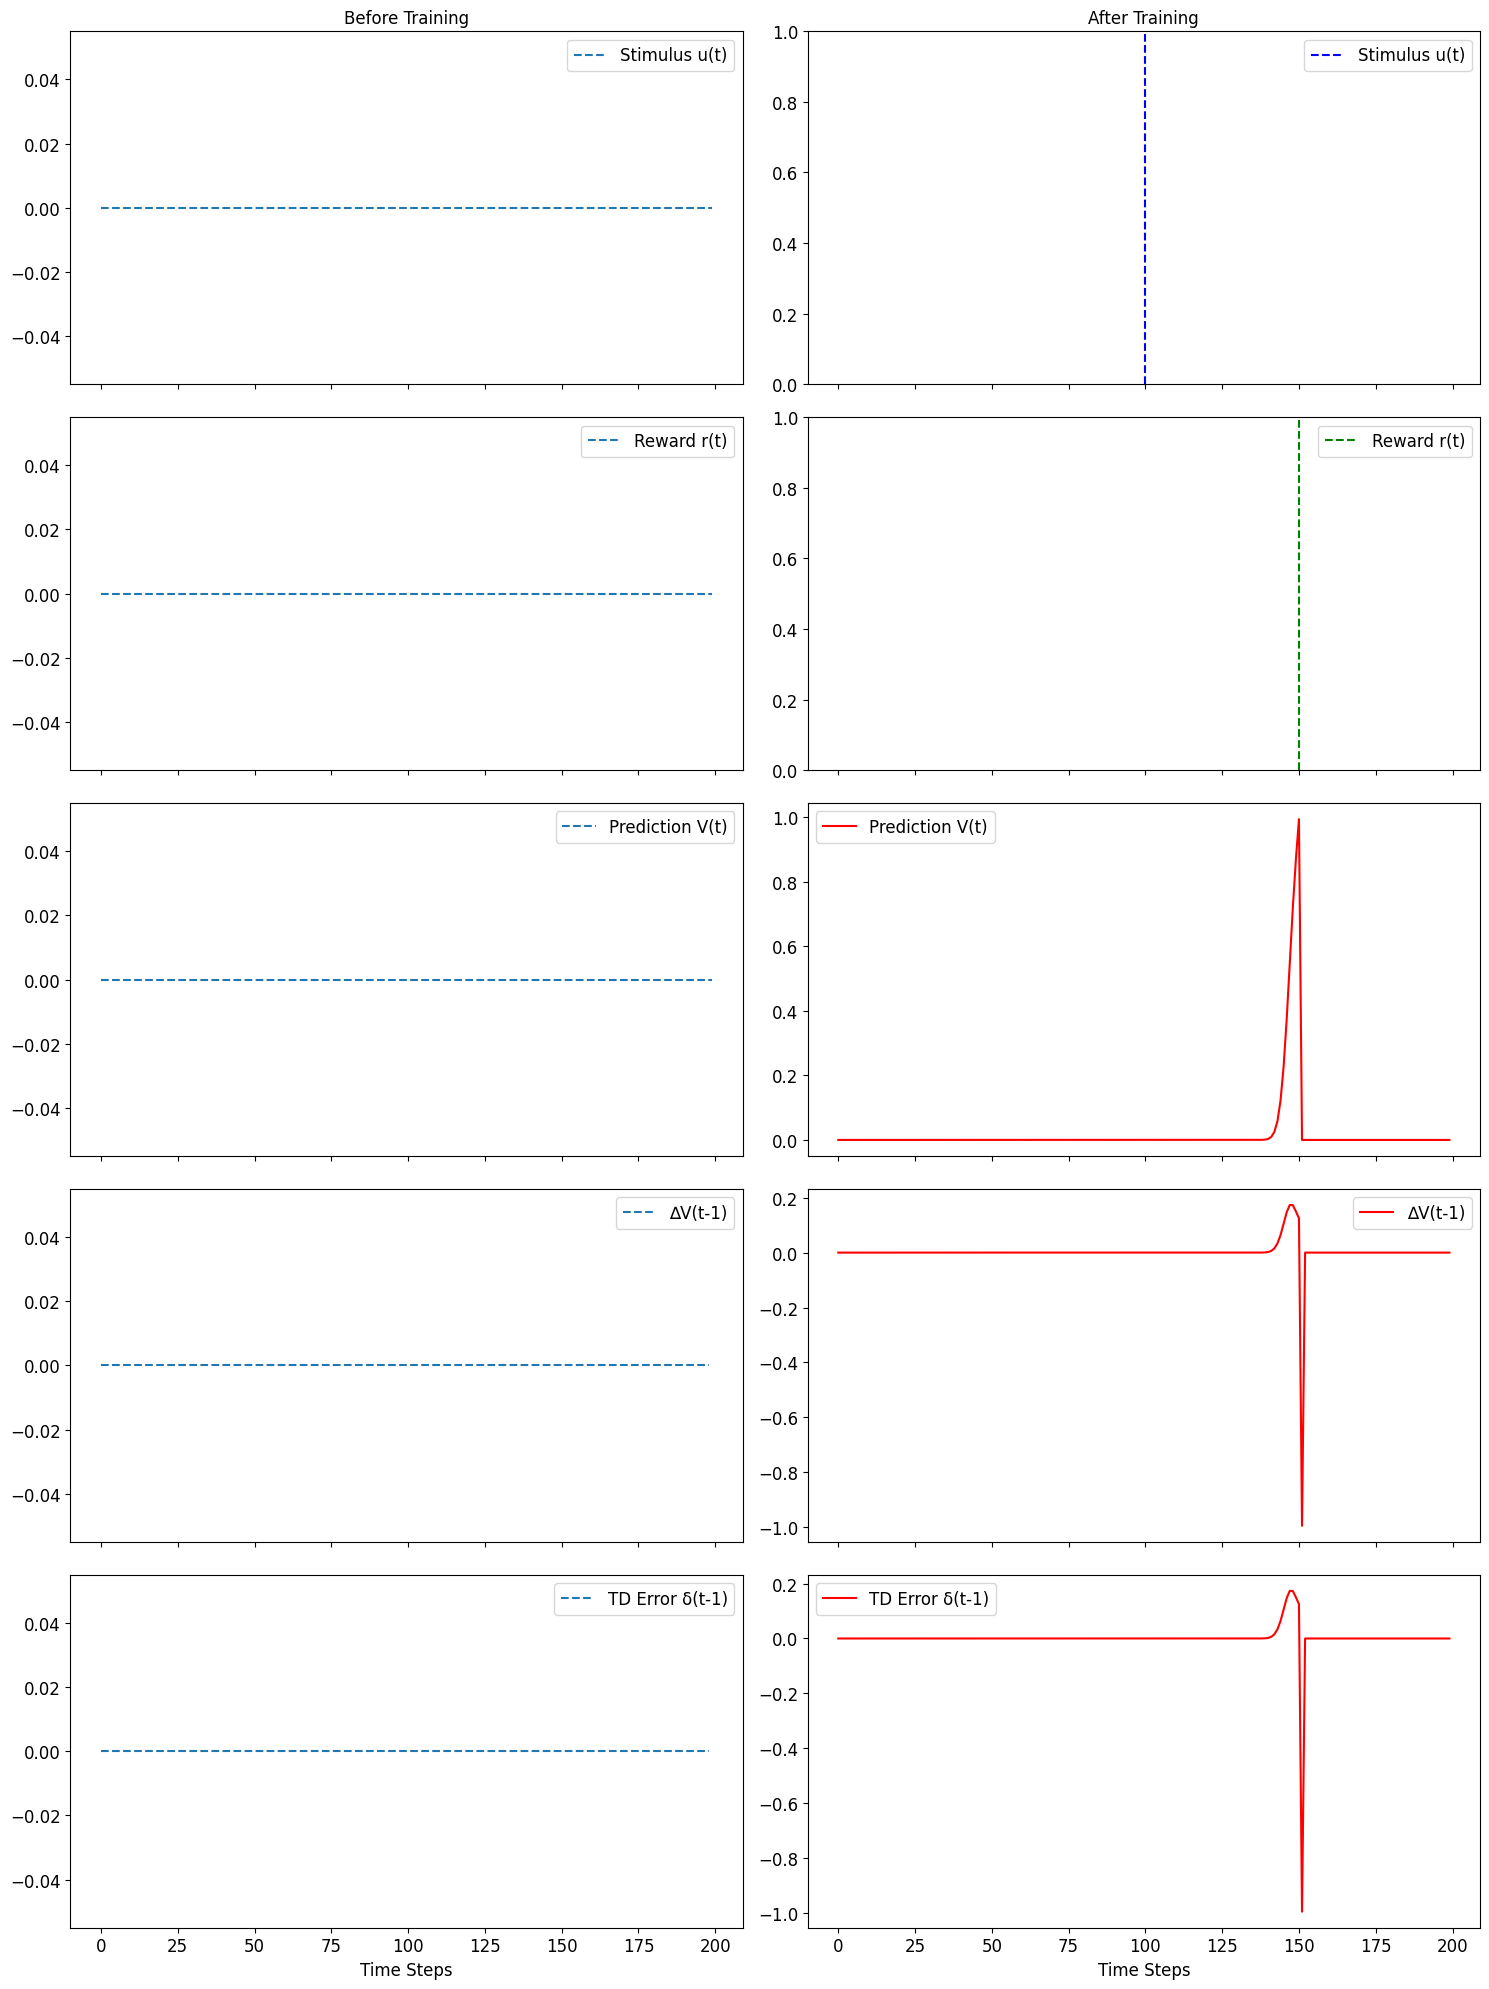

In [18]:
n_time_steps = 200
alpha = 0.1
gamma = 0.9
num_trials = 50
stimulus_time = 100
reward_time = 150

td = TemporalDifferenceLearning(n_time_steps, alpha, gamma)
predictions, deltas = td.run_trials(reward_time, stimulus_time, num_trials)
td.plot_results(predictions, deltas, stimulus_time, reward_time)

### Recreate Figure 9.2
- **3D Surface Plot of Temporal Difference Errors**: Shows how TD errors reduce over trials as the model learns, starting high and converging to near-zero values.

## 2. Simulating with different parameters

### 2.1 Reward timing

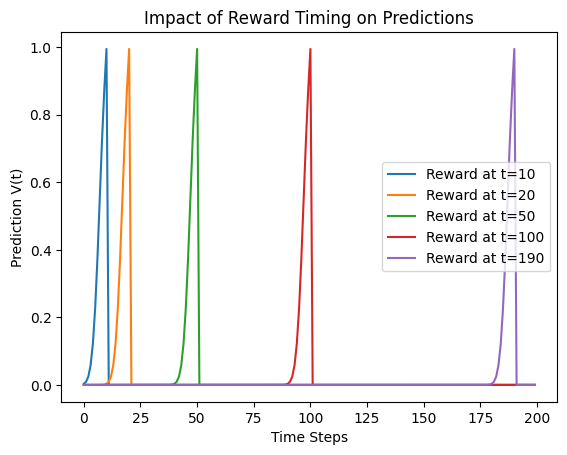

In [19]:
reward_timings = [10, 20, 50, 100, 190]  # Different reward delays
stimulus_time = 50  # Fixed stimulus time

for reward_time in reward_timings:
    td = TemporalDifferenceLearning(n_time_steps=200, alpha=0.1, gamma=0.9)
    predictions, deltas = td.run_trials(reward_time=reward_time, stimulus_time=stimulus_time, num_trials=50)
    plt.plot(predictions[-1], label=f'Reward at t={reward_time}')

plt.title("Impact of Reward Timing on Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Prediction V(t)")
plt.legend()
plt.show()


* Early reward: Prediction peaks closer to the reward time, with minimal influence on earlier time steps.
* Delayed reward: The prediction spreads further backward, associating the stimulus with the delayed reward.

### 2.2 Learning rate

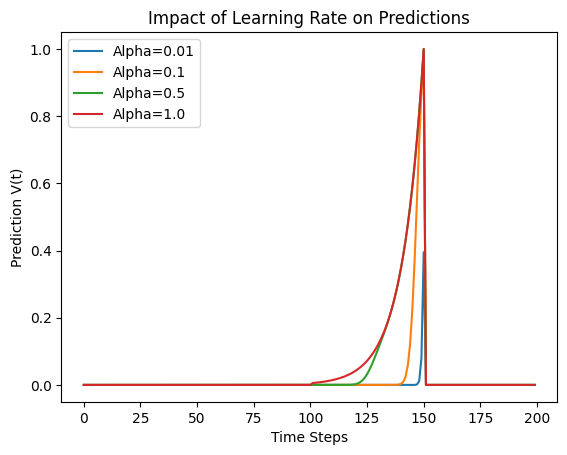

In [20]:
learning_rates = [0.01, 0.1, 0.5, 1.0]  # Test different learning rates
reward_time = 150
stimulus_time = 100

for alpha in learning_rates:
    td = TemporalDifferenceLearning(n_time_steps=200, alpha=alpha, gamma=0.9)
    predictions, deltas = td.run_trials(reward_time=reward_time, stimulus_time=stimulus_time, num_trials=50)
    plt.plot(predictions[-1], label=f'Alpha={alpha}')

plt.title("Impact of Learning Rate on Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Prediction V(t)")
plt.legend()
plt.show()


* Small α: Slower learning; predictions take more trials to converge.
* Large α: Faster learning but risk of instability.

### 2.3 Multiple rewards

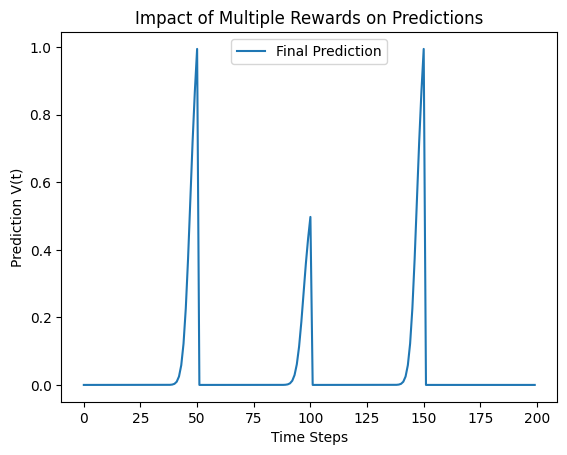

In [25]:
reward_vector = np.zeros(200)
reward_vector[50] = 1.0  # First reward
reward_vector[100] = 0.5  # Second reward
reward_vector[150] = 1.0 # Third reward
stimulus_time = 100

td = TemporalDifferenceLearning(n_time_steps=200, alpha=0.1, gamma=0.9)
predictions_over_trials = []

for trial in range(50):  # Run 50 trials
    td.update(reward_vector)
    predictions_over_trials.append(np.copy(td.V))

# Plot the predictions after the last trial
plt.plot(predictions_over_trials[-1], label="Final Prediction")
plt.title("Impact of Multiple Rewards on Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Prediction V(t)")
plt.legend()
plt.show()


### 2.4 Stochastic rewards

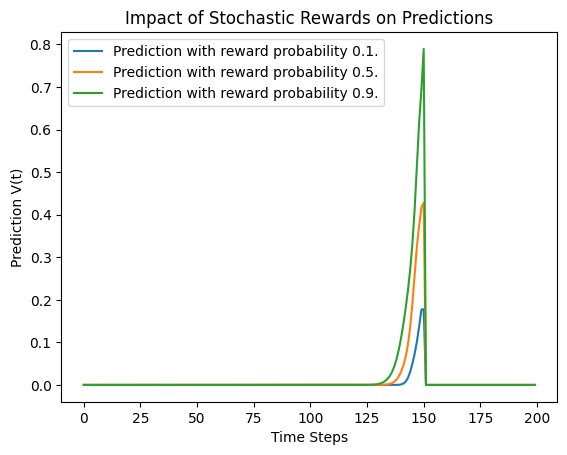

In [64]:
stimulus_time = 100
reward_time = 150
reward_probabilities = [0.1, 0.5, 0.9]  # 80% chance of delivering reward

td = TemporalDifferenceLearning(n_time_steps=200, alpha=0.1, gamma=0.9)

for reward_probability in reward_probabilities:
    predictions_over_trials = []
    for trial in range(50):  # Run 50 trials
        reward_vector = np.zeros(200)
        if np.random.rand() <= reward_probability:  # Random reward delivery
            reward_vector[reward_time] = 1.0
        td.update(reward_vector)
        predictions_over_trials.append(np.copy(td.V))
    plt.plot(predictions_over_trials[-1], label=f"Prediction with reward probability {reward_probability}.")

# Plot the predictions after the last trial

plt.title("Impact of Stochastic Rewards on Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Prediction V(t)")
plt.legend()
plt.show()


1. **High Reward Probability (p = 0.9):**
   - Predictions converge smoothly to the expected values.
   - Learning is stable as rewards are delivered consistently, reinforcing the value association.
     
2. **Medium Reward Probability (p = 0.5):**
   - Predictions converge more slowly compared to \( p = 0.9 \) due to irregular reward delivery.
   - The value association is noisier as rewards are only delivered half the time.
     

3. **Low Reward Probability (p = 0.1):**
   - Predictions converge very slowly and are noisier.
   - The model struggles to associate time steps with future rewards due to the sporadic delivery of rewards.


## 3. Successor learning

In [4]:
# define maze
maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = (5, 7)

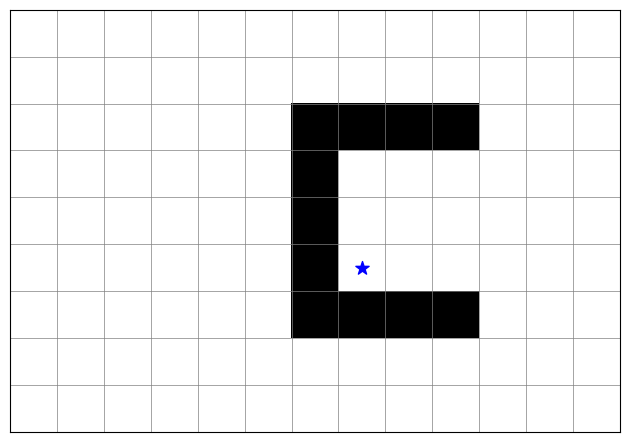

In [5]:
def plot_maze(maze):
    plt.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        plt.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        plt.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)

    plt.xticks([])
    plt.yticks([])

plot_maze(maze)
plt.scatter(start[1], start[0], marker='*', color='blue', s=100)
plt.tight_layout()
# plt.savefig('maze.png')
plt.show()

### 4.1 Random Walk

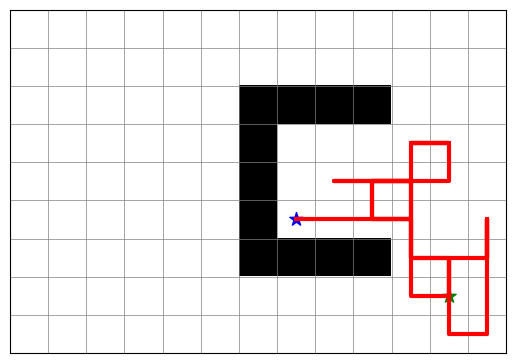

In [8]:
####################################
############## Part 1 ##############
####################################

def random_walk(maze, start, n_steps):
    # perform a single random walk in the given maze, starting from start, performing n_steps random moves
    # moves into the wall and out of the maze boundary are not possible

    # initialize list to store positions
    positions = [start]

    # Current Position
    current_position = np.array(start)

    # Define possible moves
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
    # perform random steps...
    for _ in range(n_steps):
        while True:
            # Pick a random move
            move = moves[np.random.choice(len(moves))]

            # Compute the new position
            next_position = current_position + np.array(move)

            # Check if the move is valid
            if (
                    0 <= next_position[0] < maze.shape[0] and  # Vertical bounds
                    0 <= next_position[1] < maze.shape[1] and  # Horizontal bounds
                    maze[next_position[0], next_position[1]] == 0  # not a wall
            ):
                current_position = next_position  # Update position
                break

        # Append the valid position
        positions.append(tuple(current_position))

    # return a list of positions
    return positions

def plot_path(maze, path):
    # plot a maze and a path in it
    plot_maze(maze)
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], c='red', lw=3)
    plt.scatter(path[0, 1], path[0, 0], marker='*', color='blue', s=100)
    plt.scatter(path[-1, 1], path[-1, 0], marker='*', color='green', s=100)
    plt.show()

# plot a random path
path = random_walk(maze, start, 40)
plot_path(maze, path)

**Random Walk Path in the Maze**: Demonstrates a valid trajectory through the maze, avoiding walls and boundaries.


### 4.2 Learn from Trajectory

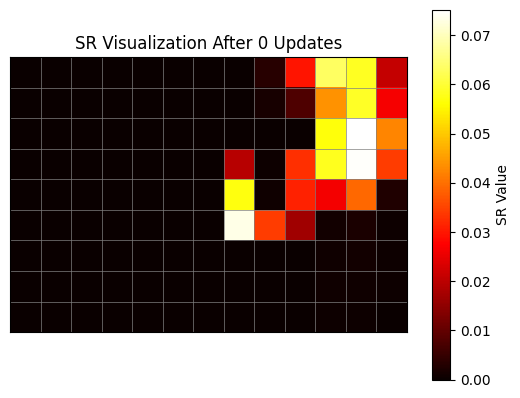

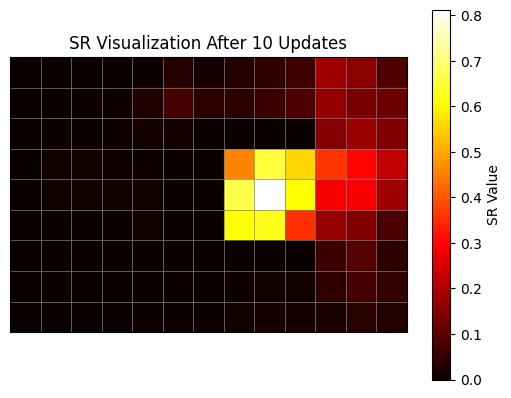

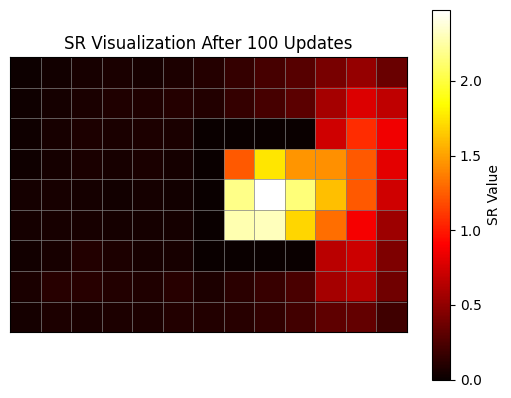

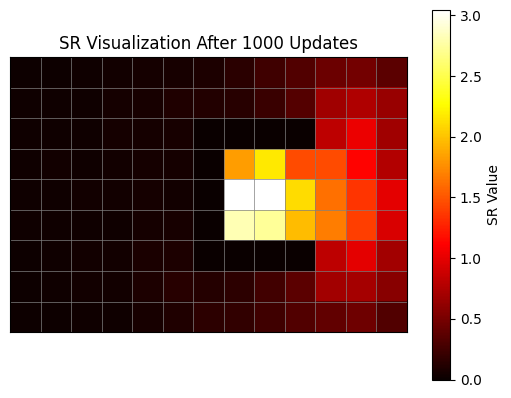

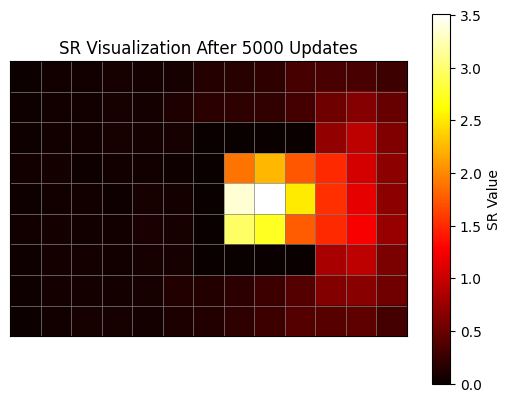

In [7]:
####################################
############## Part 2 ##############
####################################


def learn_from_traj(succ_repr, trajectory, maze_shape, gamma=0.98, alpha=0.02):
    # Write a function to update a given successor representation (for the state at which the trajectory starts) using an example trajectory
    # using discount factor gamma and learning rate alpha
    # Grid shape

    # Convert trajectory grid positions to linear indices
    linear_trajectory = [pos[0] * maze_shape[1] + pos[1] for pos in trajectory]

    # Get the starting state index
    start_state = linear_trajectory[0]

    # Initialize discounted trajectory vector
    discounted_trajectory = np.zeros_like(succ_repr[start_state])

    # Populate the discounted trajectory
    for t, future_state in enumerate(linear_trajectory):
        discounted_trajectory[future_state] += gamma ** t

    # Update the successor representation for the starting state
    succ_repr[start_state] = (1 - alpha) * succ_repr[start_state] + alpha * discounted_trajectory

    # return the updated successor representation
    return succ_repr

# initialize successor representation
n_states = maze.shape[0] * maze.shape[1]  # Total number of states (9 * 13 = 117)
succ_repr = np.zeros((n_states, n_states)) # Initialization as 117x117

# sample a whole bunch of trajectories (reduce this number if this code takes too long, but it shouldn't take longer than a minute with reasonable code)
for i in range(5001):
    # sample a path (we use 340 steps here to sample states until the discounting becomes very small)
    path = random_walk(maze, start, 340)
    # update the successor representation
    succ_repr = learn_from_traj(succ_repr, path, maze.shape, alpha=0.02)  # choose a small learning rate

    # occasionally plot it
    if i in [0, 10, 100, 1000, 5000]:
        start_state_index = start[0] * maze.shape[1] + start[1]
        reshaped_sr = succ_repr[start_state_index].reshape(maze.shape)

        plot_maze(maze)
        plt.imshow(reshaped_sr, cmap='hot')
        plt.title(f"SR Visualization After {i} Updates")
        plt.colorbar(label="SR Value")
        plt.show()


**SR Visualization After Updates**: Successor Representation converges to reflect state visitation probabilities as the model learns from sampled paths.

### 4.3 Transition Matrix Computation

In [15]:
####################################
############## Part 3 ##############
####################################


def compute_transition_matrix(maze):
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    grid_shape = maze.shape
    n_states = grid_shape[0] * grid_shape[1] # Total number of states ( 9x13 grid)
    transition_matrix = np.zeros((n_states, n_states)) # Initialize transition matrix

    # Define possible moves:
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1)] # up, Down, Left, Right

    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    for row in range(grid_shape[0]):
        for col in range(grid_shape[1]):
            # Linear index for the current state
            current_state = row * grid_shape[1] + col

            # Skip walls
            if maze[row, col] == 1:
                continue  # Leave the row as zeros (no transitions possible)

            # Compute valid transitions
            valid_transitions = []
            for move in moves:
                next_row, next_col = row + move[0], col + move[1]
                if (
                    0 <= next_row < grid_shape[0] and  # Within row bounds
                    0 <= next_col < grid_shape[1] and  # Within column bounds
                    maze[next_row, next_col] == 0  # Not a wall
                ):
                    next_state = next_row * grid_shape[1] + next_col
                    valid_transitions.append(next_state)

                    # Assign equal probabilities to all valid transitions
                    for next_state in valid_transitions:
                        transition_matrix[current_state, next_state] = 1 / len(valid_transitions)


    
    # normalize transitions if necessary
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero for wall states
    transition_matrix = transition_matrix / row_sums

    # remove NaNs if necessary
    transition_matrix = np.nan_to_num(transition_matrix)

    return transition_matrix

transitions = compute_transition_matrix(maze)
transitions

array([[0.        , 0.5       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.        ,
        0.33333333],
       [0.        , 0.        , 0.        , ..., 0.        , 0.5       ,
        0.        ]])

## 4.2 Succesor Representation Computation

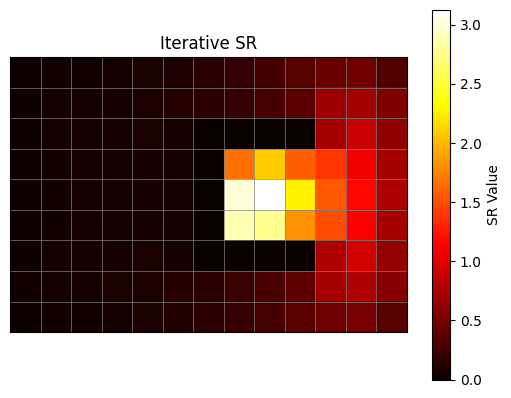

In [11]:
####################################
############## Part 4 ##############
####################################

def compute_sr(transitions, i, j, maze_shape, gamma=0.98):
    # given a transition matrix and a specific state (i, j), compute the successor representation of that state with discount factor gamma
    n_states = transitions.shape[0]

    # Convert (i, j) coordinates to linear index
    start_state = i * maze_shape[1] + j

    # initialize things (better to represent the current discounted occupancy as a vector here)
    current_discounted_occupancy = np.zeros(n_states)
    current_discounted_occupancy[start_state] = 1  # Start state occupancy is 1

    # Initialize total SR vector
    total = np.zeros(n_states)

    # iterate for a number of steps
    for step in range(340):  # Steps to ensure discounting becomes negligible
        # Update total SR
        total += current_discounted_occupancy

        # Propagate to the next step
        current_discounted_occupancy = gamma * (current_discounted_occupancy @ transitions)

    # return the successor representation, maybe reshape your vector into the maze shape now
    return total.reshape(maze_shape)

transitions = compute_transition_matrix(maze)

# compute state representation for start state
i, j = start
sr = compute_sr(transitions, i, j, maze.shape, 0.98)

# plot state representation
plot_maze(maze)
plt.imshow(sr, cmap='hot')
plt.title("Iterative SR")
plt.colorbar(label="SR Value")
plt.show()


- **Iterative SR Visualization**: Shows how SR values decrease with increasing distance from the starting state, following the discount factor’s influence.

### 4.5 Analytical Solution

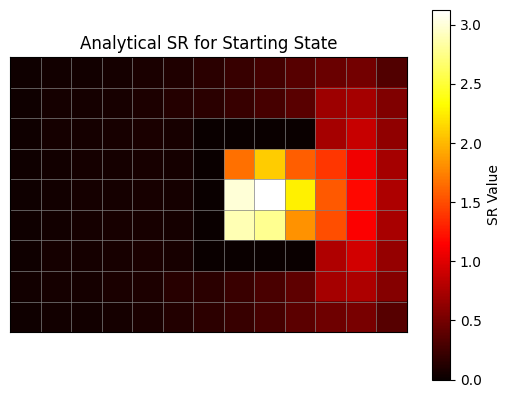

In [16]:
############################################
############## Part 5 (Bonus) ##############
############################################

# You're on your own now

def compute_sr_analytical(transitions, gamma=0.98):
    """
       Compute the successor representation (SR) analytically for all states.

       Parameters:
       - transitions: Transition matrix (117 x 117).
       - gamma: Discount factor.

       Returns:
       - sr_matrix: Successor representation matrix (117 x 117).
   """
    # Identity matrix
    identity = np.eye(transitions.shape[0])

    # Compute the SR matrix using (I - gamma * T)^-1
    sr_matrix = np.linalg.inv(identity - gamma * transitions)

    return sr_matrix
# Compute the analytical SR for the entire grid
analytical_sr = compute_sr_analytical(transitions, gamma=0.98)

# Extract and reshape the SR for the starting state
start_state_index = start[0] * maze.shape[1] + start[1]
start_sr_analytical = analytical_sr[start_state_index].reshape(maze.shape)

# Visualize the analytical SR for the starting state
plot_maze(maze)
plt.imshow(start_sr_analytical, cmap='hot')
plt.title("Analytical SR for Starting State")
plt.colorbar(label='SR Value')
plt.show()

**Analytical SR Visualization**: Confirms that the analytical approach provides the same SR structure as the iterative method, with faster computation.